# FID

## Previous DDPM

In [1]:
from tinyai import *

import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

import timm
import einops
from fastcore.foundation import L
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim,Tensor
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

set_output()
toggle_mpl_cmap()

setting cmap: gray_r


In [2]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

import torchvision.transforms.functional as TF

xmean,xstd = 0.286, 0.353

@inplace
def transformi(b): b[x] = [TF.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[x]]

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=16, pin_memory=True)

In [3]:
betamin, betamax, nsteps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, nsteps)
alpha = 1 - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

bs = 4
t = torch.randint(0, nsteps, (bs,), dtype=torch.long)
alphabar_t = alphabar[t]

In [4]:
from tqdm.notebook import tqdm

def noisify(x0, alphabar):
    device = x0.device
    bs = len(x0)
    t = torch.randint(0, nsteps, (bs,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    # expanding each alphabar_t to a single item in the batch
    alphabar_t = alphabar[t][:, None, None, None]

    # weighted average of original image and noise
    xt = x0 * alphabar_t.sqrt() + (1 - alphabar_t).sqrt() * epsilon

    # noised image, timestep : epsilon (noise target)
    return xt, t.to(device), epsilon


@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, nsteps):
    device = next(model.parameters()).device
    xt = torch.randn(sz, device=device)
    preds = []

    for t in tqdm(list(reversed(range(nsteps)))):
        # contains a batch of items at time T. Starts at max (e.g. 1000) which is noise
        t_batch = torch.full((sz[0],), t, device=device, dtype=torch.long)

        if t == 0:  # final step, add no noise, use the image
            z = torch.zeros_like(xt, device=device)
            alphabar_t1 = torch.tensor(1)
        else:
            z = torch.randn_like(xt)
            alphabar_t1 = alphabar[t - 1]

        alpha_t = alpha[t]
        alphabar_t = alphabar[t]
        beta_t = 1 - alpha_t
        betabar_t = 1 - alphabar_t
        betabar_t1 = 1 - alphabar_t1
        sigma_t = sigma[t]

        noise_pred = model(xt, t_batch)  # previous image

        # attempting to completely remove the noise
        x0_hat = ( (xt - betabar_t.sqrt() * noise_pred) / alphabar_t.sqrt() ).clamp(-1, 1)

        # how much we keep of the estimated noise
        x0_coeff = alphabar_t1.sqrt() * beta_t / betabar_t

        # how much we keep of the previous image
        xt_ceoff = alpha_t.sqrt() * betabar_t1 / betabar_t

        added_noise = sigma_t * z

        # weighted average of the previous image and the estimated noise + added noise
        xt = x0_hat * x0_coeff + xt * xt_ceoff + added_noise

        # as we converge on t=0, our prediction of x0 will be more accurate,
        # so we weight x0_coeff and less xt_coeff

        preds.append(to_cpu(xt))
    return preds

In [5]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, xb, t):
        return super().forward(xb, t).sample # type: ignore

ddpm_model = torch.load("fashion_ddpm_5epochs.pkl")

  0%|          | 0/1000 [00:00<?, ?it/s]

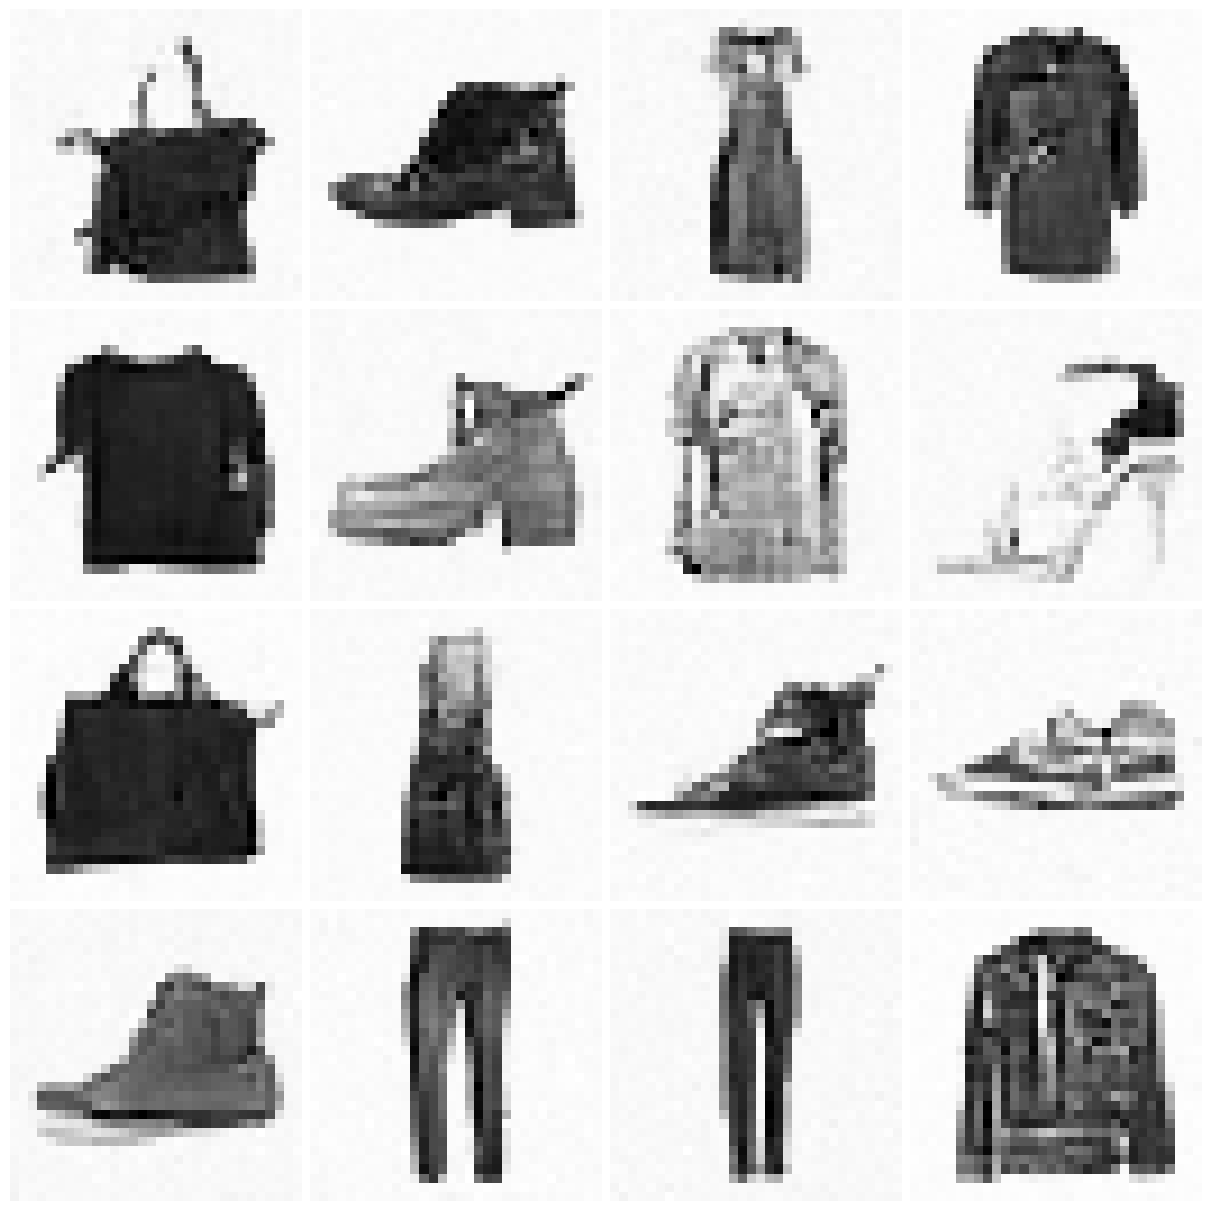

In [6]:
bs = 256
samples = sample(ddpm_model, (bs, 1, 32, 32), alpha, alphabar, sigma, 1000)
show_images(samples[-1][:16])

In [7]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

import torchvision.transforms.functional as TF

xmean,xstd = 0.286, 0.353

@inplace
def transformi(b): b[x] = [TF.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[x]]

bs = 256
tds = dsd.with_transform(transformi)


def collate_ddpm(b):
    return noisify(default_collate(b)[x], alphabar)

def dl_ddpm(ds, bs):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=16, pin_memory=True)

dls = DataLoaders(MultDL(dl_ddpm(tds['train'], bs), 1), dl_ddpm(tds['test'], bs))

## FID for realz

In [8]:
s = samples[-1]*2-1
s.shape

torch.Size([256, 1, 32, 32])

In [9]:
def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    # act = nn.ReLU
    norm = nn.BatchNorm2d
    drop = 0.25

    layers = [
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm),
        ResBlock(16, 32, stride=2, act=act, norm=norm),
        ResBlock(32, 64, stride=2, act=act, norm=norm),
        ResBlock(64, 128, stride=2, act=act, norm=norm),
        ResBlock(128, 256, stride=2, act=act, norm=norm),
        nn.Dropout(p=drop),
        ResBlock(256, 512, stride=2, act=act, norm=norm),
        # get features
        # nn.Dropout(p=drop),
        nn.Flatten(),
        # nn.Linear(512, 10, bias=False),
        # nn.BatchNorm1d(10),
    ]
    return nn.Sequential(*layers)

clf_model = get_model()

In [15]:
from torch import nn
def always_zero(*x): return tensor(0.)

learn = Trainer(clf_model, DataLoaders([], [(s, torch.zeros(s.size(0)))]), always_zero, model_dir="./")
learn.load("mnist_clf.pkl")

ModuleNotFoundError: No module named 'tinyai.nn'

In [ ]:
feats, _ = learn.capture_preds()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

       0     eval   0.0000


In [ ]:
feats = feats.float().squeeze()
means = feats.mean(0)
feats.shape

torch.Size([256, 512])

In [ ]:
feats_gt = clf_model(next(iter(dls.valid))[0].to(def_device)).float().squeeze()
feats_gt.shape

torch.Size([256, 512])

In [ ]:
feats.cov().mean()

tensor(0.021)

In [ ]:
(feats.mean(0).to(def_device) @ feats_gt.mean(0))

tensor(61.060, device='cuda:0', grad_fn=<DotBackward0>)